<a href="https://colab.research.google.com/github/abhy-kumar/microgrid/blob/main/MicroGridpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy pandas matplotlib scikit-learn seaborn

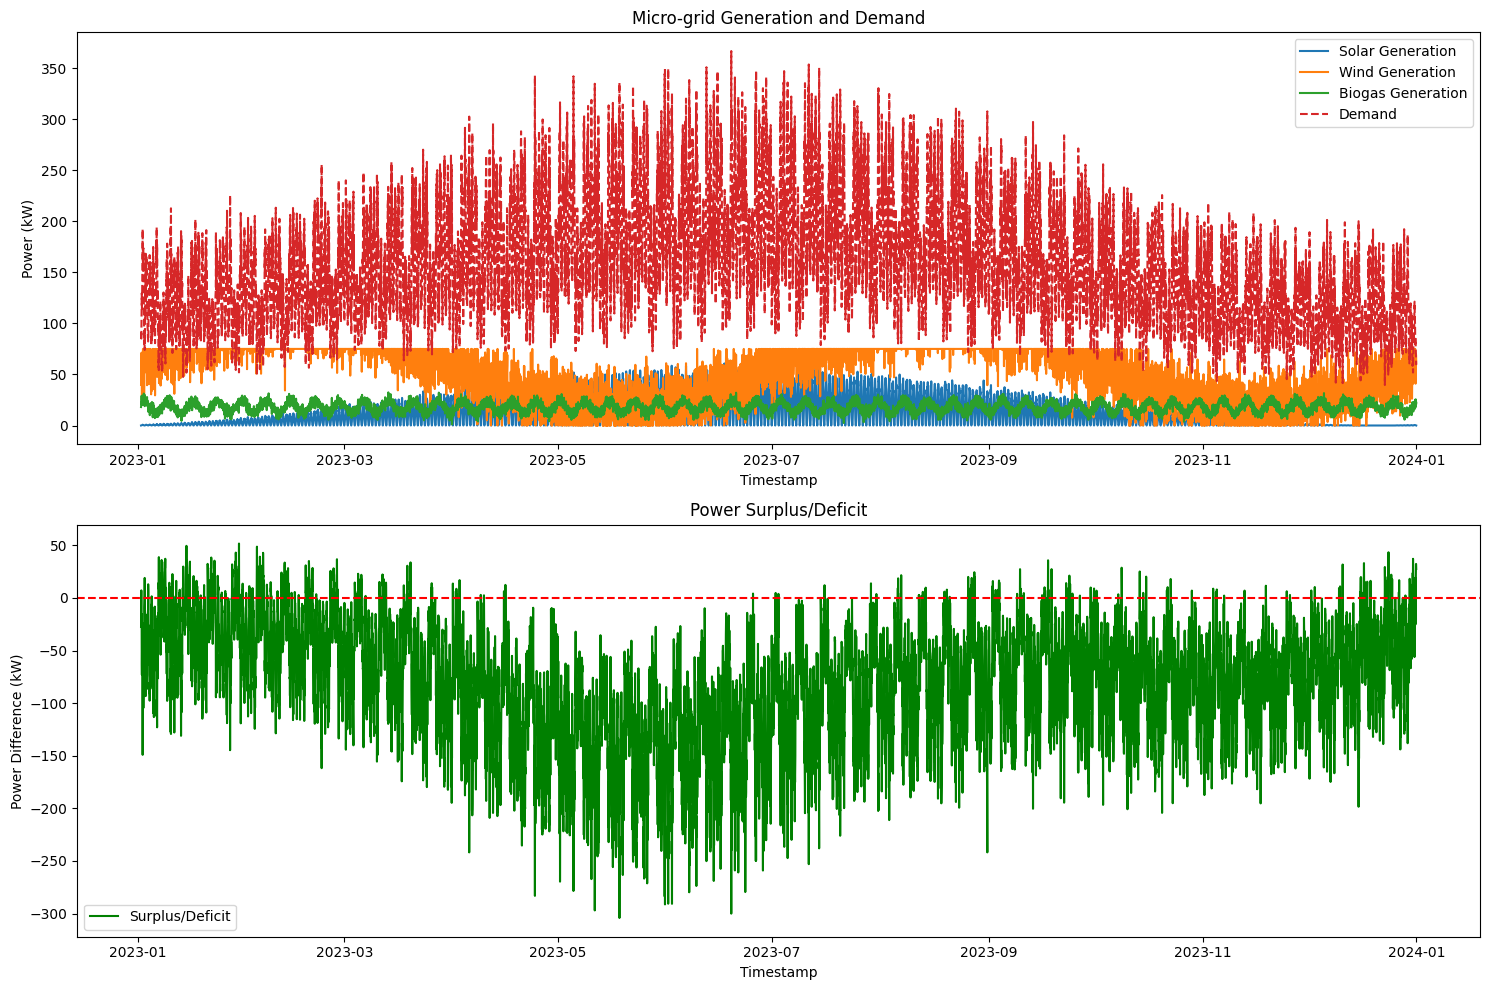

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fold 1:
Mean Squared Error: 862.45
Root Mean Squared Error: 29.37
R-squared Score: 0.66

Feature Importances:
Solar_Generation: 0.1055
Wind_Generation: 0.0059
Biogas_Generation: 0.0160
Hour: 0.0726
DayOfWeek: 0.0365
Month: 0.0023
Lagged_Demand_1: 0.7333
Lagged_Demand_24: 0.0280


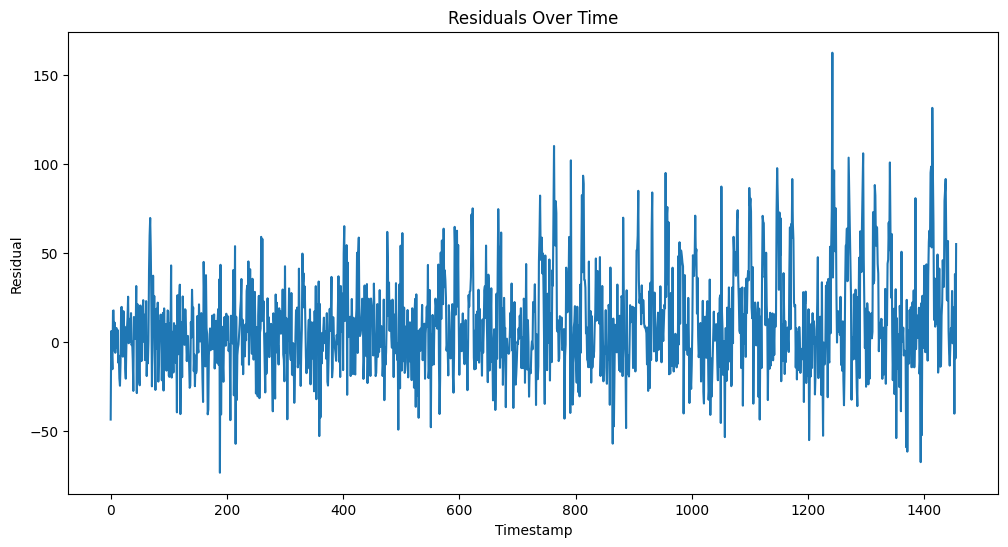

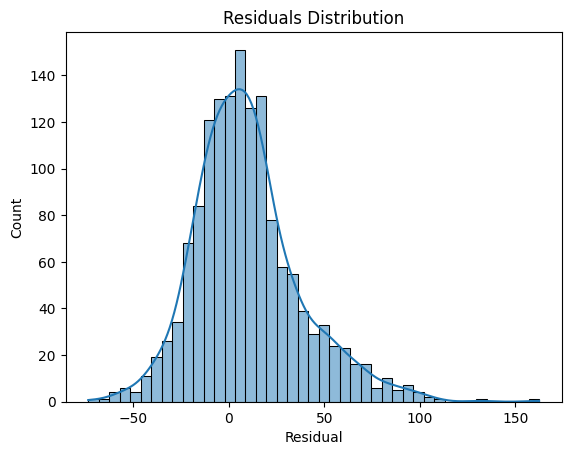

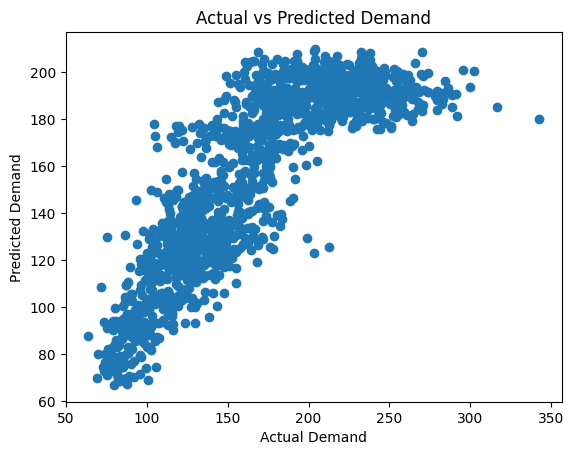

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fold 2:
Mean Squared Error: 639.21
Root Mean Squared Error: 25.28
R-squared Score: 0.82

Feature Importances:
Solar_Generation: 0.1644
Wind_Generation: 0.0098
Biogas_Generation: 0.0149
Hour: 0.0295
DayOfWeek: 0.0506
Month: 0.0047
Lagged_Demand_1: 0.6988
Lagged_Demand_24: 0.0272


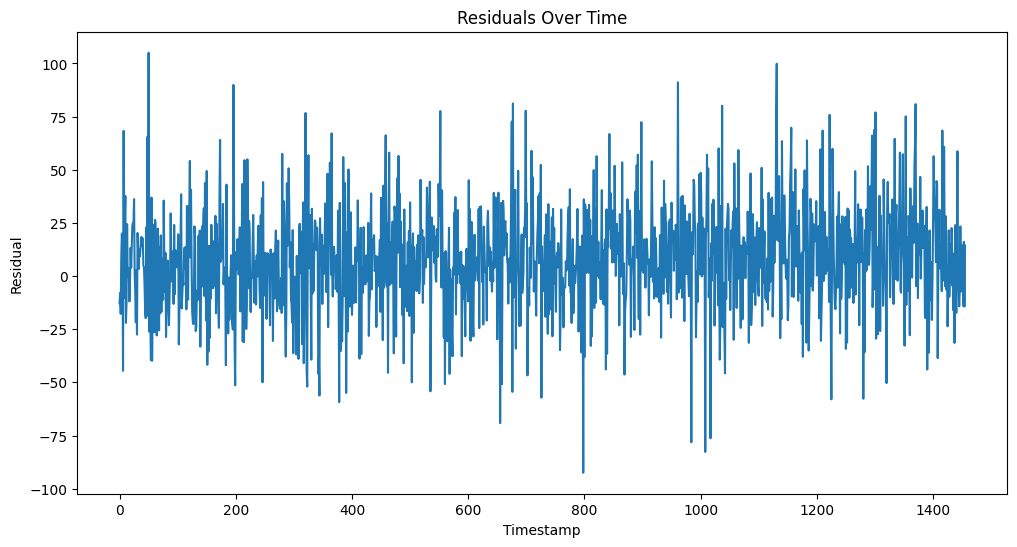

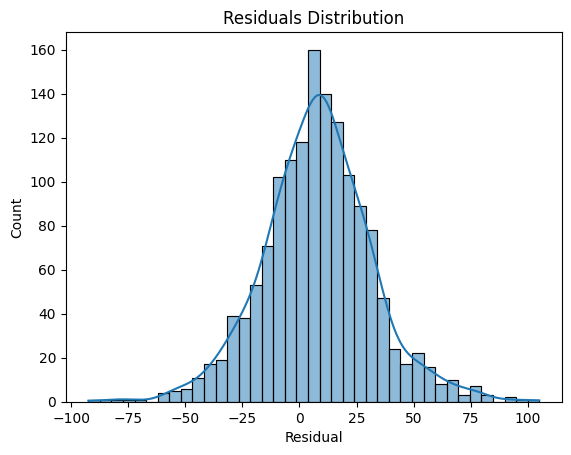

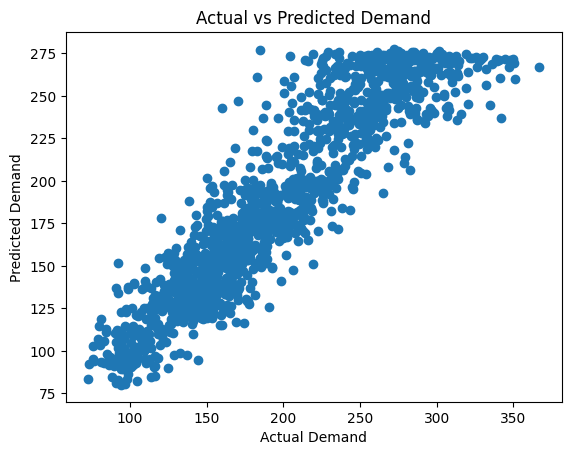

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fold 3:
Mean Squared Error: 521.15
Root Mean Squared Error: 22.83
R-squared Score: 0.84

Feature Importances:
Solar_Generation: 0.1140
Wind_Generation: 0.0080
Biogas_Generation: 0.0099
Hour: 0.0188
DayOfWeek: 0.0265
Month: 0.0052
Lagged_Demand_1: 0.8028
Lagged_Demand_24: 0.0147


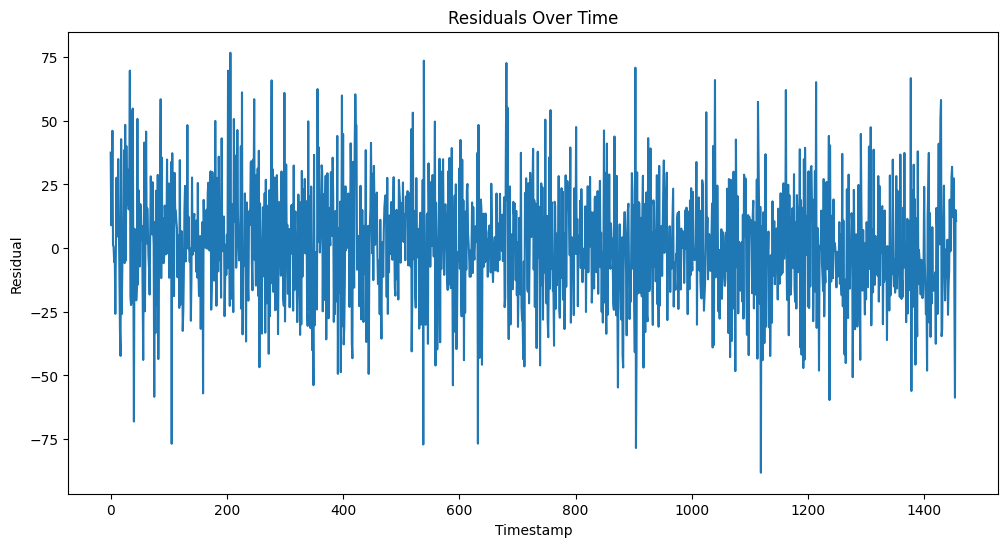

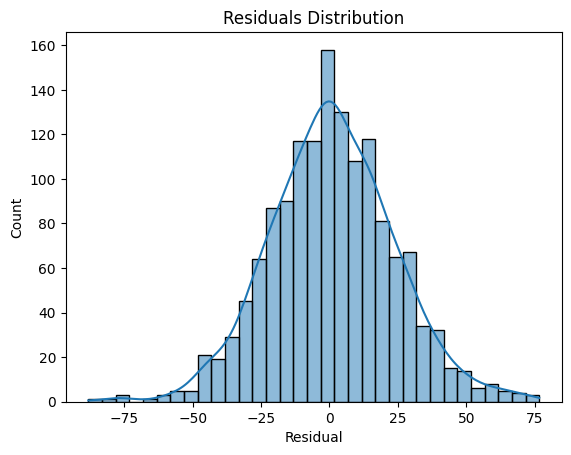

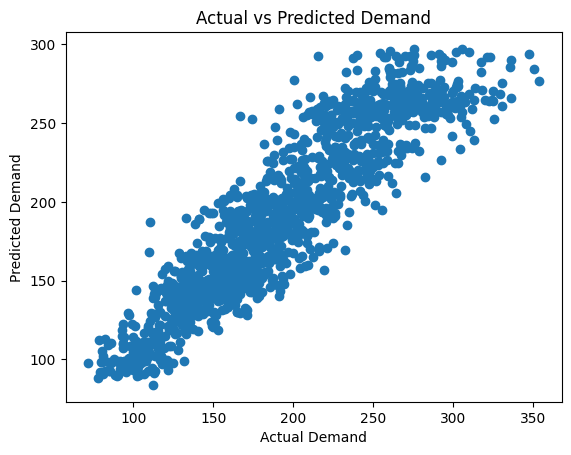

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fold 4:
Mean Squared Error: 437.50
Root Mean Squared Error: 20.92
R-squared Score: 0.79

Feature Importances:
Solar_Generation: 0.1471
Wind_Generation: 0.0056
Biogas_Generation: 0.0091
Hour: 0.0130
DayOfWeek: 0.0427
Month: 0.0058
Lagged_Demand_1: 0.7614
Lagged_Demand_24: 0.0153


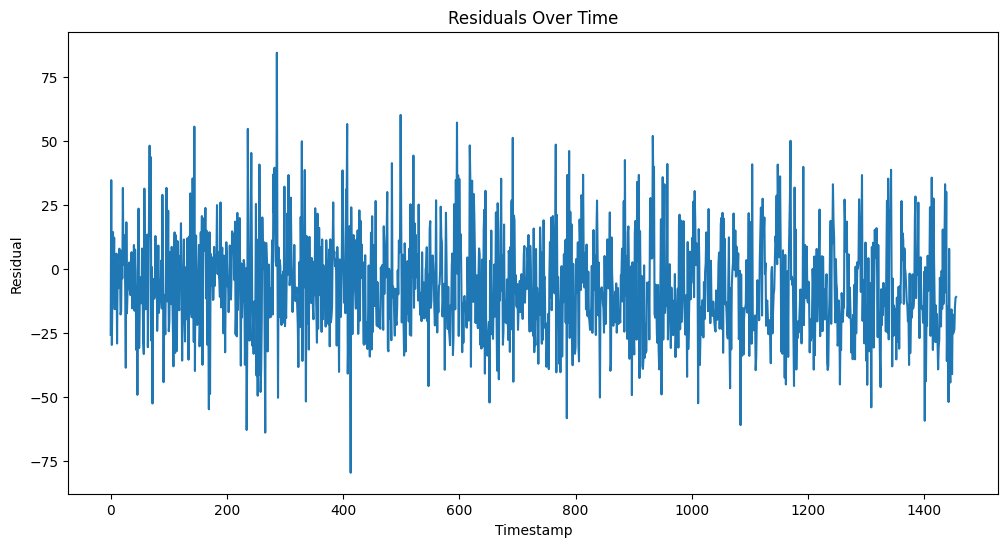

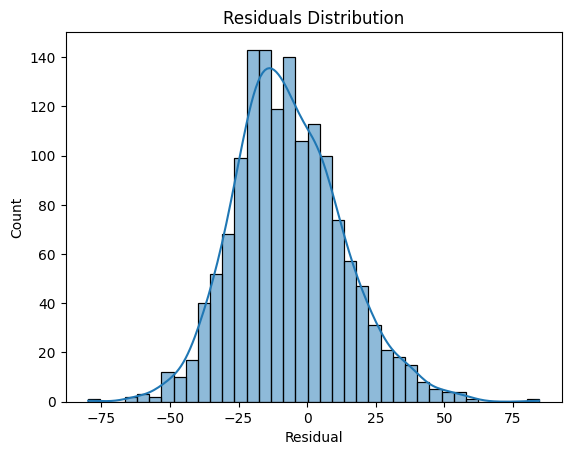

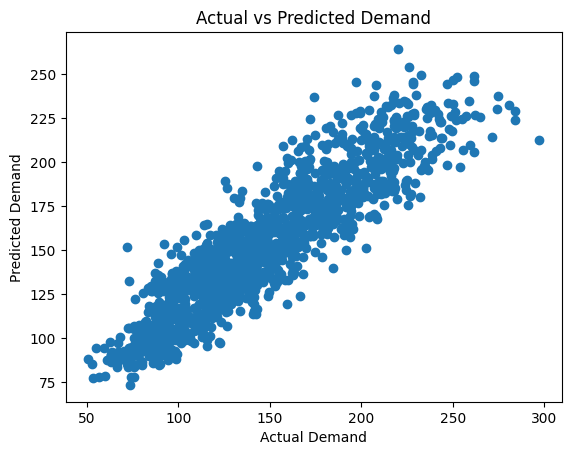

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fold 5:
Mean Squared Error: 270.55
Root Mean Squared Error: 16.45
R-squared Score: 0.77

Feature Importances:
Solar_Generation: 0.1492
Wind_Generation: 0.0050
Biogas_Generation: 0.0090
Hour: 0.0135
DayOfWeek: 0.0395
Month: 0.0040
Lagged_Demand_1: 0.7631
Lagged_Demand_24: 0.0169


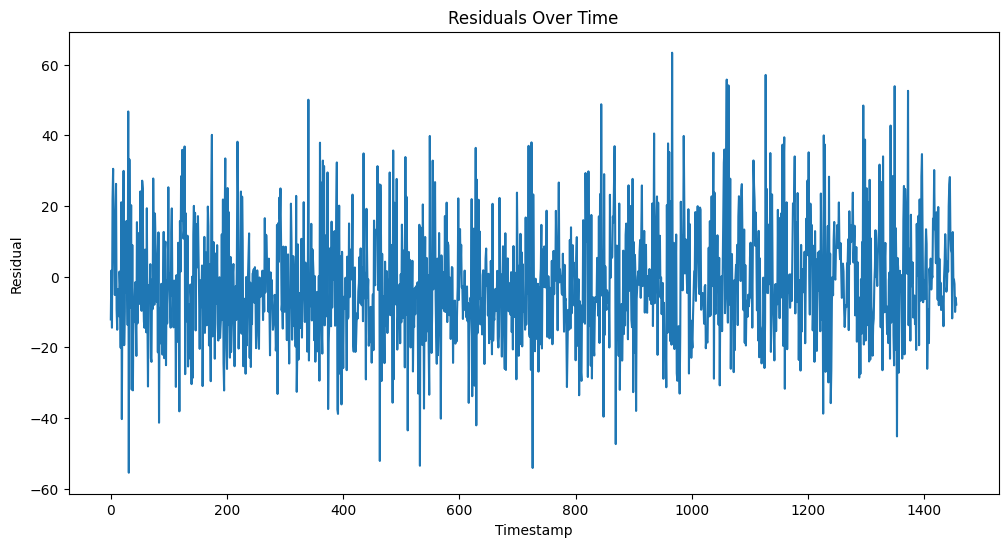

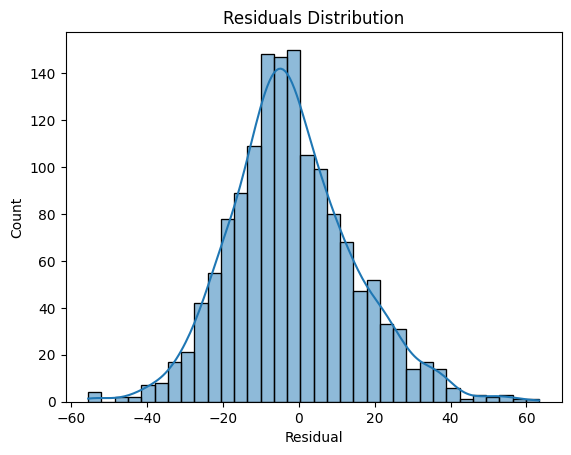

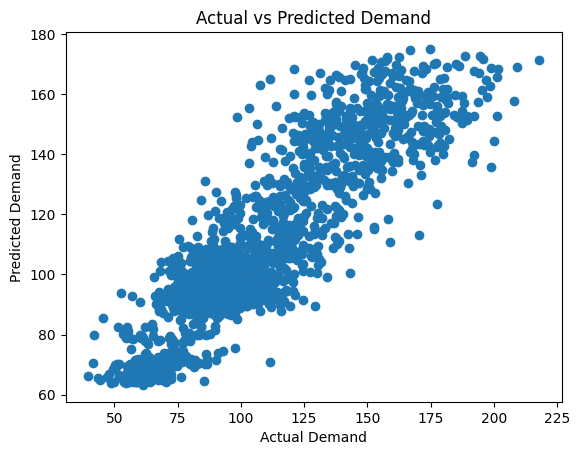


Sample Demand Prediction:
With generation: Solar=30, Wind=40, Biogas=20
At hour 12, day of week 3, month 6
With lagged demand: Previous hour=100, 24 hours ago=110
Predicted Demand: 132.74 kW

Simulation data saved to 'microgrid_simulation_data.csv'


In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

class MicroGridSimulation:
    def __init__(self, days=365, random_seed=42):
        """
        Initialize the micro-grid simulation

        Parameters:
        - days: Number of days to simulate
        - random_seed: Seed for reproducibility
        """
        np.random.seed(random_seed)
        self.days = days
        self.timestamps = pd.date_range(start='2023-01-01', periods=days*24, freq='h')  # Changed 'H' to 'h'

        # Generation Capacity (in kW)
        self.solar_capacity = 50  # 50 kW solar farm
        self.wind_capacity = 75   # 75 kW wind turbines
        self.biogas_capacity = 30 # 30 kW biogas generator

    def generate_solar_output(self):
        """
        Simulate solar power generation with seasonal and daily variations
        """
        # Seasonal variation
        day_of_year = np.array([t.dayofyear for t in self.timestamps])
        seasonal_factor = np.sin((day_of_year - 80) * (2 * np.pi / 365)) * 0.5 + 0.5

        # Daily variation (hour of day)
        hour_of_day = np.array([t.hour for t in self.timestamps])
        daily_factor = np.cos((hour_of_day - 12) * (np.pi / 12)) * 0.5 + 0.5

        # Random noise
        noise = np.random.normal(0, 0.1, len(self.timestamps))

        # Combine factors
        solar_output = self.solar_capacity * seasonal_factor * daily_factor * (1 + noise)
        return np.maximum(solar_output, 0)  # Ensure non-negative values

    def generate_wind_output(self):
        """
        Simulate wind power generation with realistic variations
        """
        # Base wind speed variation
        base_wind_speed = 10 + 5 * np.sin(np.linspace(0, 4*np.pi, len(self.timestamps)))

        # Add randomness to wind speed
        wind_speed = base_wind_speed + np.random.normal(0, 2, len(self.timestamps))

        # Wind power curve (simplified)
        def wind_power_curve(speed):
            # Typical wind turbine power curve characteristics
            cut_in_speed = 3  # m/s
            rated_speed = 12  # m/s
            cut_out_speed = 25  # m/s

            power = np.zeros_like(speed)
            mask = (speed >= cut_in_speed) & (speed < rated_speed)
            power[mask] = self.wind_capacity * ((speed[mask] - cut_in_speed) / (rated_speed - cut_in_speed))

            mask = (speed >= rated_speed) & (speed < cut_out_speed)
            power[mask] = self.wind_capacity

            return np.maximum(power, 0)

        return wind_power_curve(wind_speed)

    def generate_biogas_output(self):
        """
        Simulate biogas power generation with base load and variations
        """
        # Base load with some randomness
        base_load = self.biogas_capacity * 0.6  # 60% of capacity
        variation = np.random.normal(0, 0.1 * self.biogas_capacity, len(self.timestamps))

        # Add weekly maintenance cycles
        maintenance_cycle = np.sin(np.linspace(0, 2*np.pi*self.days/7, len(self.timestamps))) * 0.2

        biogas_output = base_load + variation + maintenance_cycle * self.biogas_capacity
        return np.maximum(biogas_output, 0)

    def generate_demand(self):
        """
        Simulate realistic electricity demand
        """
        # Base demand with daily and seasonal variations
        base_demand = 100  # Average base demand in kW

        # Seasonal variation
        day_of_year = np.array([t.dayofyear for t in self.timestamps])
        seasonal_factor = np.sin((day_of_year - 80) * (2 * np.pi / 365)) * 0.3 + 1

        # Hourly variation (peak during day, low at night)
        hour_of_day = np.array([t.hour for t in self.timestamps])
        hourly_factor = (np.sin((hour_of_day - 6) * (np.pi / 12)) * 0.5 + 1.5)

        # Weekend vs. weekday variation
        weekday = np.array([t.weekday() for t in self.timestamps])
        weekend_factor = np.where((weekday >= 5), 0.8, 1.2)

        # Random noise
        noise = np.random.normal(0, 0.1, len(self.timestamps))

        demand = base_demand * seasonal_factor * hourly_factor * weekend_factor * (1 + noise)
        return np.maximum(demand, 0)

    def simulate_microgrid(self):
        # Generate data for each component
        solar_output = self.generate_solar_output()
        wind_output = self.generate_wind_output()
        biogas_output = self.generate_biogas_output()
        demand = self.generate_demand()

        # Create DataFrame
        df = pd.DataFrame({
            'Timestamp': self.timestamps,
            'Solar_Generation': solar_output,
            'Wind_Generation': wind_output,
            'Biogas_Generation': biogas_output,
            'Total_Generation': solar_output + wind_output + biogas_output,
            'Demand': demand
        })

        # Add lagged demand features
        df['Lagged_Demand_1'] = df['Demand'].shift(1)
        df['Lagged_Demand_24'] = df['Demand'].shift(24)

        # Adjust demand based on previous surplus/deficit
        df['Surplus_Deficit'] = df['Total_Generation'] - df['Demand']
        df['Demand_Adjustment'] = df['Surplus_Deficit'].shift(1) * 0.1
        df['Demand'] += df['Demand_Adjustment']
        df['Demand'] = df['Demand'].clip(lower=0)

        # Drop rows with NaN values due to lag features
        df = df.dropna()

        return df

    def train_demand_prediction_model(self, df):
        # Extract temporal features
        df['Hour'] = df['Timestamp'].dt.hour
        df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
        df['Month'] = df['Timestamp'].dt.month

        # Prepare features
        features = ['Solar_Generation', 'Wind_Generation', 'Biogas_Generation',
                    'Hour', 'DayOfWeek', 'Month', 'Lagged_Demand_1', 'Lagged_Demand_24']
        X = df[features].values
        y = df['Demand'].values

        # Time-based split
        tscv = TimeSeriesSplit(n_splits=5)
        fold = 1

        for train_index, test_index in tscv.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Scale features
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            # Hyperparameter tuning
            param_grid = {
                'n_estimators': [100, 200, 300],
                'max_depth': [5, 10, 15],
                'min_samples_split': [2, 5, 10]
            }

            grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                                       param_grid=param_grid,
                                       cv=TimeSeriesSplit(n_splits=5),
                                       scoring='neg_mean_squared_error',
                                       verbose=1,
                                       n_jobs=-1)

            # Fit the grid search
            grid_search.fit(X_train_scaled, y_train)

            # Get the best model
            best_model = grid_search.best_estimator_

            # Evaluate the best model
            y_pred = best_model.predict(X_test_scaled)
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test, y_pred)

            print(f"Fold {fold}:")
            print(f"Mean Squared Error: {mse:.2f}")
            print(f"Root Mean Squared Error: {rmse:.2f}")
            print(f"R-squared Score: {r2:.2f}")
            fold += 1

            # Feature importances
            print("\nFeature Importances:")
            for feature, importance in zip(features, best_model.feature_importances_):
                print(f"{feature}: {importance:.4f}")

            # Residual analysis
            residuals = y_test - y_pred
            plt.figure(figsize=(12, 6))
            plt.plot(residuals)
            plt.title('Residuals Over Time')
            plt.xlabel('Timestamp')
            plt.ylabel('Residual')
            plt.show()

            # Residual distribution
            sns.histplot(residuals, kde=True)
            plt.title('Residuals Distribution')
            plt.xlabel('Residual')
            plt.show()

            # Actual vs Predicted
            plt.scatter(y_test, y_pred)
            plt.xlabel('Actual Demand')
            plt.ylabel('Predicted Demand')
            plt.title('Actual vs Predicted Demand')
            plt.show()

        return best_model, scaler

    def visualize_microgrid_data(self, df):
        """
        Create visualizations of the micro-grid simulation

        Parameters:
        - df: DataFrame with microgrid simulation data
        """
        plt.figure(figsize=(15, 10))

        # Generation and Demand Plot
        plt.subplot(2, 1, 1)
        plt.plot(df['Timestamp'], df['Solar_Generation'], label='Solar Generation')
        plt.plot(df['Timestamp'], df['Wind_Generation'], label='Wind Generation')
        plt.plot(df['Timestamp'], df['Biogas_Generation'], label='Biogas Generation')
        plt.plot(df['Timestamp'], df['Demand'], label='Demand', linestyle='--')
        plt.title('Micro-grid Generation and Demand')
        plt.xlabel('Timestamp')
        plt.ylabel('Power (kW)')
        plt.legend()

        # Surplus/Deficit Plot
        plt.subplot(2, 1, 2)
        plt.plot(df['Timestamp'], df['Surplus_Deficit'], label='Surplus/Deficit', color='green')
        plt.title('Power Surplus/Deficit')
        plt.xlabel('Timestamp')
        plt.ylabel('Power Difference (kW)')
        plt.axhline(y=0, color='r', linestyle='--')
        plt.legend()

        plt.tight_layout()
        plt.show()

# ... (previous code remains unchanged)

def main():
    # Create simulation
    sim = MicroGridSimulation(days=365)

    # Run simulation
    microgrid_data = sim.simulate_microgrid()

    # Visualize data
    sim.visualize_microgrid_data(microgrid_data)

    # Train prediction model
    model, scaler = sim.train_demand_prediction_model(microgrid_data)

    # Example of using the model for prediction
    # Include all features: Solar, Wind, Biogas, Hour, DayOfWeek, Month, Lagged_Demand_1, Lagged_Demand_24
    sample_input = np.array([[30, 40, 20, 12, 3, 6, 100, 110]])  # Example values for all 8 features
    sample_input_scaled = scaler.transform(sample_input)
    predicted_demand = model.predict(sample_input_scaled)
    print("\nSample Demand Prediction:")
    print(f"With generation: Solar={sample_input[0][0]}, Wind={sample_input[0][1]}, Biogas={sample_input[0][2]}")
    print(f"At hour {sample_input[0][3]}, day of week {sample_input[0][4]}, month {sample_input[0][5]}")
    print(f"With lagged demand: Previous hour={sample_input[0][6]}, 24 hours ago={sample_input[0][7]}")
    print(f"Predicted Demand: {predicted_demand[0]:.2f} kW")

    # Optional: Save data to CSV
    microgrid_data.to_csv('microgrid_simulation_data.csv', index=False)
    print("\nSimulation data saved to 'microgrid_simulation_data.csv'")

if __name__ == "__main__":
    main()